### Wind BOAs
In this notebook, wind bid-offer acceptance data from April 23 to March 25 is fetched from NESO API, processed and analyzed as illustrated below. This analysis highlights that wind power curtailment is increasing every year. 

**Data Processing**
- BOA volumes for each settlement period by generators are fetched from two different urls for April 23 to March 24, April 24 to March 25. Both of these are combined to analyze two years data. https://www.neso.energy/data-portal/wind-bmu-boa-volumes
- The negative values of BOA volume represent that generators were requested to reduce the output volume. The given volume is in MW, an extra column is created for presenting curtailment in MWh units by multiplying by 0.5 due to half-an hour settlement period. 
- There is no null values and thus, data imputation method was not explored in the analysis.
- Regions of wind warms were added by extracting information from  (https://www.neso.energy/data-portal/day-ahead-wind-forecast/day_ahead_wind_bmu_forecast).

**Outcome**
- Among all regions, south Scotland has the highest installed wind capacity, followed by the north Scotland.
- In the period of April 23 to March 24, the total curtailment was 5.24. In the following year it increased almost by 66% to 8.7 TWh. 
- In the whole analysis period, monthly curtailment was maximum in December 24 of 1.36 TWh. 
- Offshore wind power is more curtailed than onshore probably due to grid constraints.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import urllib3

In [6]:
def neso_api_to_df(api: str):
    '''Fetches data from the NESO API and converts it into a Pandas DataFrame'''
    try:
        http = urllib3.PoolManager()
        request = http.request('GET', api)
        json_response = request.json() # NESO api returns data in JSON format
        listed_data = json_response['result']['records']
        df = pd.DataFrame(listed_data)
        return df
    except Exception as e:
        print(f"API request error: {e}")
        return pd.DataFrame()

### Regional Capacity

In [9]:
#Extracting information of wind farms by regions
wind_forecast_url = 'https://api.neso.energy/api/3/action/datastore_search?resource_id=90e581e9-2d7f-4eaa-8fe0-6e323ee0f5f7&limit=200000'
wind_forecast_df = neso_api_to_df(wind_forecast_url)
#Tidying up columns and regions name
wind_forecast_df.columns = [column.lower() for column in wind_forecast_df.columns]
wind_forecast_df.region = wind_forecast_df.region.str.lower().str.replace(' - ', '_').str.replace(' ', '_')

# Capacity by regions
generators_region = wind_forecast_df[['generator_name', 'generator_full_name', 'region', 'capacity']]
generators_region = generators_region.drop_duplicates() # 
total_cap_by_region = generators_region[['region', 'capacity']].groupby('region').sum().sort_values(by = 'capacity', ascending = False)/1000
total_cap_by_region.columns = ['capacity (GW)']
total_cap_by_region

,capacity (GW)
region,
south_scotland,4.07995
north_scotland,3.51955
north_sea_east_england,3.25600
north_sea_north_scotland,3.15100
north_sea_yorkshire_&_humber,3.00200
irish_sea_north_west_england,1.83200
north_sea_south_east_england,0.91900
north_sea_east_midlands,0.82400
irish_sea_north_wales,0.76900


### Historical Wind BOA data

In [10]:
#April 23 to March 24 data API
wind_boas_23_api = 'https://api.neso.energy/api/3/action/datastore_search?resource_id=1edaa5fe-86fe-41b4-95b9-55e9ec45fab0&limit=2000000'
df_23 = neso_api_to_df(wind_boas_23_api)
# April 24 to March 25 data API
wind_boas_24_api = 'https://api.neso.energy/api/3/action/datastore_search?resource_id=d3fbf6c1-7688-4486-8716-b5af0c895a5a&limit=2000000'
df_24 = neso_api_to_df(wind_boas_24_api)

In [11]:
wind_curtail = pd.concat([df_23, df_24], axis = 0)
wind_curtail.columns
# Tidy up column names
wind_curtail.columns = [column.lower() for column in wind_curtail.columns]
wind_curtail.columns = [column[1:] if column.startswith("_") else column for column in wind_curtail.columns]
# wind_curtail.info()
wind_curtail.date =pd.to_datetime(wind_curtail.date)
start_date, end_date = wind_curtail.date.min(), wind_curtail.date.max()
print('The data is from ', start_date.date(), 'to', end_date.date())
diff_days = abs((end_date-start_date).days)

print('The given BOA volume is converted from MW to MWh')
wind_curtail.loc[:, 'volume_mwh'] = wind_curtail.boa_volume*0.5
#Adding generators regions to curtailment dataframe
merged_df = pd.merge(wind_curtail, generators_region, on = ['generator_name', 'generator_full_name'], how = 'left')

The data is from  2023-04-01 to 2025-03-08
The given BOA volume is converted from MW to MWh


**Curtailment by Generators**

In [12]:
curtail_by_generator = merged_df[['generator_name', 'region','volume_mwh']].groupby('generator_name').sum().sort_values(by = 'volume_mwh')
curtail_by_generator.loc[:, 'volume_twh'] = curtail_by_generator.volume_mwh*1e-6
curtail_by_generator[['region',  'volume_twh']].head(10)

,region,volume_twh
generator_name,,
SGRWO-6,north_sea_north_scotlandnorth_sea_north_scotla...,-1.666509
SGRWO-1,north_sea_north_scotlandnorth_sea_north_scotla...,-1.231982
MOWEO-1,north_sea_north_scotlandnorth_sea_north_scotla...,-0.877936
SGRWO-3,north_sea_north_scotlandnorth_sea_north_scotla...,-0.701540
MOWEO-3,north_sea_north_scotlandnorth_sea_north_scotla...,-0.684345
MOWEO-2,north_sea_north_scotlandnorth_sea_north_scotla...,-0.680857
SGRWO-4,north_sea_north_scotlandnorth_sea_north_scotla...,-0.621286
SGRWO-5,north_sea_north_scotlandnorth_sea_north_scotla...,-0.352460
DOREW-1,north_scotlandnorth_scotlandnorth_scotlandnort...,-0.317025


**Monthly curtailment**

In [13]:
monthly_total_volume = wind_curtail[['date', 'volume_mwh']].groupby(wind_curtail['date'].dt.to_period('M')).agg({'volume_mwh': 'sum'})*(1e-6)
monthly_total_volume.rename_axis('month', inplace=True)
monthly_total_volume.rename(columns = {'volume_mwh': 'volume_twh'},inplace = True)
monthly_total_volume.sort_values(by = 'volume_twh').head(5)

,volume_twh
month,
2024-12,-1.359286
2024-08,-1.223531
2025-02,-1.153344
2024-10,-1.058448
2024-11,-0.796741


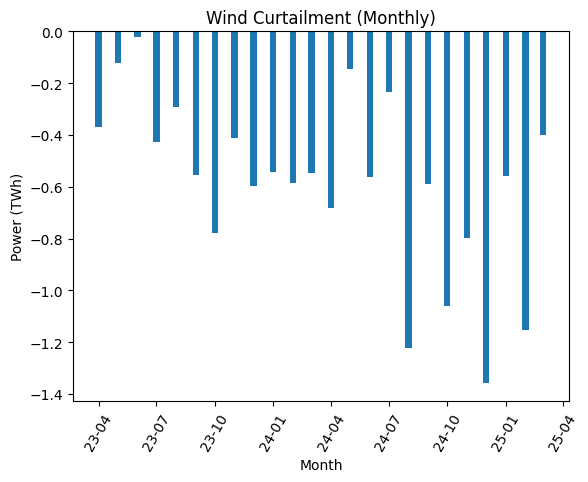

In [16]:
fig, ax = plt.subplots()
dates = pd.date_range(start_date, end_date, freq = 'MS')
ax.bar(dates, monthly_total_volume.volume_twh, width = 10)
tick_positions, tick_labels = plt.xticks()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y-%m'))
plt.xticks(rotation = 60);
plt.ylabel('Power (TWh)');
plt.title('Wind Curtailment (Monthly)');
plt.xlabel('Month');


**Annual Curtailment**

In [17]:
y2_start_date = '2024-04-01' 
sum_23 = np.round(wind_curtail[wind_curtail.date < pd.to_datetime(y2_start_date)].volume_mwh.sum()*(1e-6),2)
sum_24 = np.round(wind_curtail[wind_curtail.date >= pd.to_datetime(y2_start_date)].volume_mwh.sum()*(1e-6),2)
print('Curtailments in the year 2023/24 and 2024/25 are' , sum_23, 'and', sum_24, 'respectively.')

Curtailments in the year 2023/24 and 2024/25 are -5.24 and -8.76 respectively.
